In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import tensorflow as tf
import keras
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [212]:
#Only use this if you want to read the whole 2016 Core File
df_core = pd.read_csv("Data16/NIS_2016_Core.csv")

C:\Users\daksh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (35,36,37,38,39,40,41,42,43,44,45,46,48,49,50,55,56,57,58,59,60,61,62,63,64,65,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
#Read Filtered Data
df_new = pd.read_csv("results new/NIS_Core_Hospitalized_grouped_cci.csv")

C:\Users\daksh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (43,44,45,46,47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
#Save indices where procedures were done
ind_val = []
for i in range(0, len(df_new["i10_pr1"])):
    if isinstance(df_new["i10_pr1"][i], str) == True:
        ind_val.append(i)

In [103]:
#Dataframe now only has stroke cases where surgery was performed
refined_df = df_new.loc[ind_val]
refined_df.shape

(57724, 146)

In [104]:
np.array(refined_df.index)

array([     1,      2,      4, ..., 144984, 144985, 144991], dtype=int64)

In [105]:
#Find days where length of stay is not stored
indices_cor = np.where(refined_df['los'] >= 0)[0]

indices = np.array(refined_df.index)
indices = indices[indices_cor]

refined_df = refined_df.loc[indices]

In [130]:
#Variables to consider in the ANOVA

#Key Independent Variables
## Number of Days from Admission to Procedure 1
Ad_Pr1 = np.array(refined_df['prday1'])

#Key Baseline Variables
## Race (classify this as white (1) or non-white(0))
race = np.array(refined_df['race'])
race[race>1] = 0

## Urban-Rural Classification (Categories 1-3 ie places with >250K (1) AND Categories 4-6 ie places with <250K(0))
urb = np.array(refined_df['pl_nchs'])
urb[urb>3] = 10
urb[urb<4] = 1
urb[urb==10] = 0

## Hospital NIS
hnis = refined_df['hosp_nis']

##CCI
cci = np.array(refined_df['cci'])

## Gender
gender = np.array(refined_df['female'])

## Number of Procedures (continuous var)
num_pro = np.array(refined_df['i10_npr'])

## Age (continuous var)
age = np.array(refined_df['age'])

## Primary Payer (Categorical: Medicare vs Everything Else)
payer = np.array(refined_df['pay1'])
payer[payer>1.5] = 0
payer[payer>0.1] = 1 

#Key Outcomes Variables
## Length of Stay following procedure 1 (los - prday1)
los_follow = np.array(refined_df['los'])

## Death
dead = np.array(refined_df['died'])

## Total Charges
totchg = np.array(refined_df['totchg'])

In [131]:
#Add Hospital Data to refined_df
hosp_df = pd.read_csv('Data16/NIS_2016_Hospital.csv')

In [132]:
refined_df

,key_nis,age,age_neonate,amonth,aweekend,died,discwt,dispuniform,dqtr,drg,...,weighted_hp,weighted_rend,weighted_canc,weighted_msld,weighted_metacanc,weighted_aids,cci,bedsize,teach,control
1,10000125,52.0,NaN,5.0,1.0,0.0,5.000010,1.0,2.0,65,...,2,0,0,0,0,0,6,3,3,2
2,10000134,47.0,NaN,4.0,0.0,0.0,5.000010,5.0,2.0,65,...,2,0,0,0,0,0,4,3,3,2
4,10000206,78.0,NaN,12.0,0.0,0.0,5.000000,6.0,4.0,65,...,2,0,0,0,0,0,3,2,1,2
5,10000279,61.0,NaN,10.0,0.0,0.0,5.000010,1.0,4.0,982,...,0,0,0,0,0,0,1,3,3,2
6,10000288,55.0,NaN,1.0,1.0,0.0,5.000030,1.0,1.0,65,...,0,2,0,0,0,0,6,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144981,90979346,70.0,NaN,8.0,0.0,0.0,5.000008,6.0,3.0,65,...,0,0,0,0,0,0,2,3,3,2
144982,90979370,79.0,NaN,1.0,1.0,1.0,5.000031,20.0,1.0,3,...,0,0,0,0,0,0,1,3,3,1
144984,90979500,71.0,NaN,11.0,0.0,0.0,5.000008,5.0,4.0,23,...,0,0,0,0,0,0,2,3,3,2
144985,90979613,86.0,NaN,11.0,0.0,0.0,5.000000,5.0,4.0,65,...,0,0,0,0,0,0,2,3,2,2


In [133]:
hosp_nis = list(hosp_df['hosp_nis'])
hosp_bed = list(hosp_df['hosp_bedsize'])
hosp_teach = list(hosp_df['hosp_locteach'])
hosp_contrl = list(hosp_df['h_contrl'])

ar_nis = np.array(hnis)

ar_bed = []
ar_teach = []
ar_contrl = []

for i in ar_nis:
    index = hosp_nis.index(i)
    ar_bed.append(hosp_bed[index])
    ar_teach.append(hosp_teach[index])
    ar_contrl.append(hosp_contrl[index])
    
refined_df['bedsize'] = ar_bed
refined_df['teach'] = ar_teach
refined_df['control'] = ar_contrl

In [134]:
#Hospital Variables
##Bedsize is a categorical variable (small vs medium + big)
bedsize = np.array(refined_df['bedsize'])
bedsize[bedsize > 1.9] = 0
bedsize[bedsize > 0.9] = 1

##Teach is a categorical variable with urban/rural distinction but let's treat it as "Teaching vs Non-Teaching"
teach = np.array(refined_df['teach'])
teach[teach < 2.5] = 0
teach[teach == 3] = 1

##Control is a categorical variable that we will be dividing into governvment vs private
control = np.array(refined_df['control'])
control[control > 1.1] = 0
control[control == 1] = 1

In [145]:
#Use num diagnoses and num procedures as well. Also, change stay length to actual stay length and not length between
#procedure 1 and discharge date

analysis_df = pd.DataFrame()
analysis_df['Time to Procedure'] = Ad_Pr1
analysis_df['Race'] = race
analysis_df['Urban'] = urb
analysis_df['Gender'] = gender
analysis_df['Age'] = age
analysis_df['Payer Type'] = payer
analysis_df['Length of Stay'] = los_follow
analysis_df['Death'] = dead
analysis_df['Charges'] = totchg
analysis_df['Hospital Bedsize'] = bedsize
analysis_df['Teaching'] = teach
analysis_df['CCI'] = cci
analysis_df['Control'] = control

In [147]:
analysis_df.fillna(analysis_df.mean(), inplace=True)

X = analysis_df[['Race','Urban','Gender','Age','Payer Type','Time to Procedure','Hospital Bedsize','Teaching','Control','CCI']]
y = analysis_df['Length of Stay']

In [148]:
analysis_df.to_csv("analysis_df.csv", index=False)

In [163]:
from stargazer.stargazer import Stargazer
from pystout import pystout

In [165]:
pystout(models=[model],
       file='A.tex')

In [173]:
from statsmodels.api import OLS
model = OLS(y,X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:         Length of Stay   R-squared (uncentered):                   0.487
Model:                            OLS   Adj. R-squared (uncentered):              0.487
Method:                 Least Squares   F-statistic:                              5472.
Date:                Sun, 23 Jan 2022   Prob (F-statistic):                        0.00
Time:                        16:15:13   Log-Likelihood:                     -2.0947e+05
No. Observations:               57719   AIC:                                  4.190e+05
Df Residuals:                   57709   BIC:                                  4.190e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

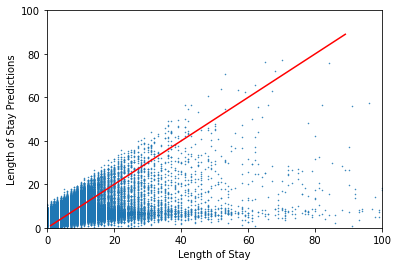

In [156]:
y_pred = model.predict(X)
plt.scatter(y, y_pred, marker = '.', s = 1)
plt.plot(range(1,90), range(1, 90), color = 'red')
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel("Length of Stay")
plt.ylabel("Length of Stay Predictions")
plt.show()

In [198]:
len(A)

7847

In [197]:
a = 0
for i in A:
    if i in B:
        a = a + 1
a

7251

In [192]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
intersection(A, B)

[6619142,
 917515,
 3342349,
 4227089,
 6488085,
 3309590,
 3112986,
 6225949,
 1671201,
 2129953,
 3964961,
 5799970,
 950323,
 3276851,
 3964981,
 1933367,
 2162747,
 2359356,
 262216,
 6225996,
 4325454,
 688217,
 4882524,
 1146979,
 327780,
 2719857,
 6848628,
 5767286,
 2785400,
 589947,
 4718718,
 2588799,
 1245317,
 4423818,
 2490507,
 3211410,
 4391064,
 6848664,
 1245349,
 5734568,
 1179819,
 5570731,
 6717612,
 6881456,
 6717617,
 4817075,
 3571893,
 4849845,
 5669049,
 5996729,
 1671362,
 2719938,
 3276997,
 5243083,
 2130126,
 2982097,
 4292818,
 6422739,
 4718804,
 2228443,
 4096219,
 2293987,
 3408101,
 1507566,
 7045358,
 6553856,
 3571969,
 4423939,
 4948229,
 4915471,
 1769744,
 1900816,
 5832979,
 4227350,
 1671451,
 3473691,
 327971,
 426280,
 2457897,
 295212,
 7110958,
 4096309,
 2294070,
 3211577,
 3113280,
 3146054,
 3014983,
 2097484,
 5931343,
 6750544,
 360786,
 3604821,
 2490710,
 5833048,
 4260185,
 3473761,
 5079398,
 3408235,
 1507692,
 5833070,
 6783344,


In [126]:
len(newdf['i10_pr1'])

7847

In [166]:
a = 0
for i in range(0, len(list(newdf['i10_pr1']))):
    if type(list(newdf['i10_pr1'])[i])==str:
        a = a + 1

In [172]:
newdf.head(4)['i10_dx1']

955     S32049A
2735    S32049D
3360    S32011A
3658    S32010A
Name: i10_dx1, dtype: object

In [160]:
#np.isnan(np.array(list(newdf['i10_pr1'])[0]))
list()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [120]:
np.where(df_core['i10_dx1'].str[0:4] == 'S320')[0]

array([    955,    2735,    3360, ..., 7133432, 7134026, 7134797],
      dtype=int64)

In [94]:
for i in range(0, 30):
    print(len(np.where(df_new[df_new.columns[18:48][i]]=='Z9282')[0]))

0
316
144
217
229
229
236
248
235
197
196
187
166
166
137
94
90
91
50
50
44
29
31
28
27
3
4
2
2
2


In [51]:
df_new.columns[55:71]

Index(['i10_pr1', 'i10_pr2', 'i10_pr3', 'i10_pr4', 'i10_pr5', 'i10_pr6',
       'i10_pr7', 'i10_pr8', 'i10_pr9', 'i10_pr10', 'i10_pr11', 'i10_pr12',
       'i10_pr13', 'i10_pr14', 'i10_pr15', 'key_nis'],
      dtype='object')

In [57]:
df_new['age']

0         73.0
1         44.0
2         78.0
3         64.0
4         71.0
          ... 
144990    76.0
144991    88.0
144992    90.0
144993    84.0
144994    87.0
Name: age, Length: 144995, dtype: float64

In [53]:
CT_use = []
for i in df_core.columns[55:71]:
    CT_use.append(len(np.where(df_core[i] == "B020ZZZ")[0]))
sum(CT_use)

3470

In [54]:
MRI_use = []
for i in df_core.columns[54:69]:
    MRI_use.append(len(np.where(df_core[i] == "B030ZZZ")[0]))
sum(MRI_use)

7506

In [65]:
charges = []
for i in range(0, len(np.unique(df_core["i10_npr"]))):
    charges.append(np.mean(df_core["totchg"].where(df_core["i10_npr"] == i)))

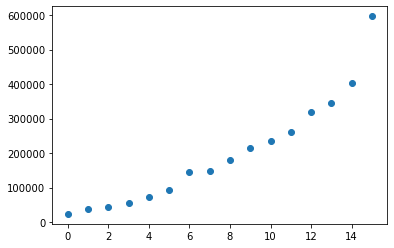

In [70]:
plt.scatter([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15], charges)

In [13]:
lol = df_core.head(50000)
lol["i10_dx10"]

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
49995    J45909
49996       NaN
49997      E039
49998       NaN
49999     M1990
Name: i10_dx10, Length: 50000, dtype: object